In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchtext
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [ ]:
features = 16
# define a simple linear VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=256)
        self.enc3 = nn.Linear(in_features=256, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=256)
        self.dec2 = nn.Linear(in_features=256, out_features=512)
        self.dec3 = nn.Linear(in_features=512, out_features=784)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def encoder(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = self.enc3(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        return x, mu, log_var

    def decoder(self, z):
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        reconstruction = torch.sigmoid(self.dec3(x))

        return reconstruction
 
    def forward(self, x):
        # encoding
        x, mu, log_var = self.encoder(x)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
  

In [ ]:
# learning parameters
epochs = 30
batch_size = 64
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_dataset, validationset = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = torch.utils.data.DataLoader(validationset, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('zero','one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [ ]:
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 1079600


In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
train_loss = []
val_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    running_loss_tr = 0.0
    running_loss_val = 0.0

    vae.train()
    for i, data in enumerate(trainloader): #tqdm(enum..), total=int(len(trainset)/trainloader.batch_size)):
        data, _ = data
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae(data)
        #bce_loss = criterion(reconstruction, data.view(-1, 784))
        #loss = final_loss(bce_loss, mu, logvar)
        loss = loss_function(reconstruction, data, mu, logvar)
        running_loss_tr += loss.item()
        loss.backward()
        optimizer.step()

    train_loss.append(running_loss_tr/len(trainloader.dataset))

    vae.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader): #tqdm(en..#, total=int(len(validationset)/validationloader.batch_size)):
          data, _ = data
          data = data.to(device)
          data = data.view(data.size(0), -1)
          reconstruction, mu, logvar = vae(data)
          #bce_loss = criterion(reconstruction, data)
          #loss = final_loss(bce_loss, mu, logvar)
          loss_val = loss_function(reconstruction, data, mu, logvar)
          running_loss_val += loss_val.item()
      
          # save the last batch input and output of every epoch
          if i == int(len(validationset)/validationloader.batch_size) - 1:
              num_rows = 8
              both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                reconstruction.view(batch_size, 1, 28, 28)[:8]))
              #save_image(both.cpu(), f'./data/output{epoch}.png', nrow=num_rows)

        val_loss.append(running_loss_val/len(validationloader.dataset))

    print('Train Loss:      {}'.format(running_loss_tr/len(trainloader.dataset)))
    print('Validation Loss: {}'.format(running_loss_val/len(validationloader.dataset)))
    print('-'*50)

  
   

Epoch 1 of 30
Train Loss:      114.19684431396485
Validation Loss: 111.33430220947265
--------------------------------------------------
Epoch 2 of 30
Train Loss:      110.86604204101563
Validation Loss: 109.24746589355469
--------------------------------------------------
Epoch 3 of 30
Train Loss:      108.85334800292969
Validation Loss: 107.83445224609375
--------------------------------------------------
Epoch 4 of 30
Train Loss:      107.3750410498047
Validation Loss: 106.64497271728516
--------------------------------------------------
Epoch 5 of 30
Train Loss:      106.25582525390625
Validation Loss: 106.1114681640625
--------------------------------------------------
Epoch 6 of 30
Train Loss:      105.43737705810547
Validation Loss: 105.49021186523437
--------------------------------------------------
Epoch 7 of 30
Train Loss:      104.70463882080078
Validation Loss: 104.40568868408204
--------------------------------------------------
Epoch 8 of 30
Train Loss:      103.96156873

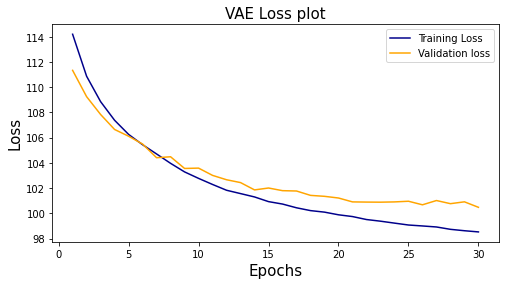

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(8,4))
epochs_plot = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
plt.plot(epochs_plot, train_loss, label = "Training Loss", color="darkblue")
plt.plot(epochs_plot, val_loss , label = "Validation loss", color = "orange")
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=15)
plt.title("VAE Loss plot", fontsize=15)
plt.legend()
#plt.savefig('VAE_Loss_plot.svg')
plt.show()

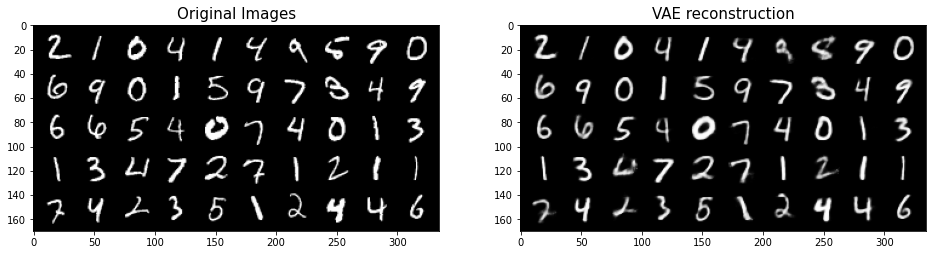

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils
plt.figure(figsize=(16,8))
vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(testloader).next()

# First visualise the original images
plt.subplot(1, 2, 1)
plt.title('Original Images', fontsize = 15)
x = torchvision.utils.make_grid(images[1:51],10,5)
x = x.clamp(0,1)
x = x.numpy()
plt.imshow(np.transpose(x,(1,2,0) ))
#plt.show()

# Reconstruct and visualise the images using the vae
plt.subplot(1, 2, 2)
plt.title('VAE reconstruction', fontsize = 15)
with torch.no_grad():

  images_recon = images.to(device)
  images_recon = images_recon.view(images_recon.size(0), -1)
  images_recon, _, _ = vae(images_recon)
  images_recon = images_recon.cpu()
  #images_recon = to_img(images_recon)
  images_recon = images_recon.view(batch_size, 1, 28, 28)
  np_imagegrid = torchvision.utils.make_grid(images_recon[1:51], 10, 5).numpy()
  plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
  plt.show()

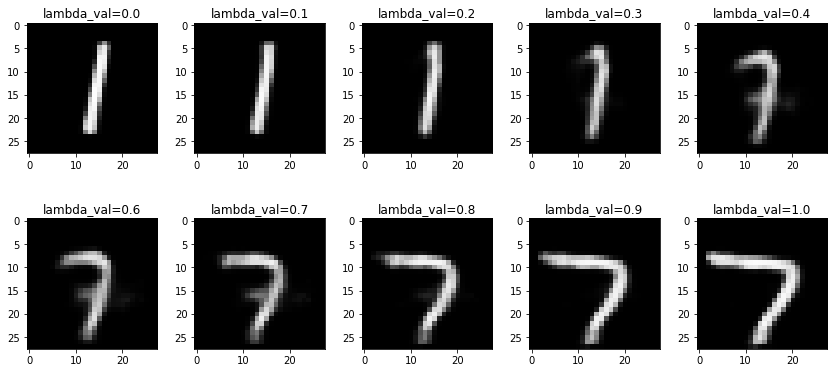

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.view(img1.size(0), -1)
        img1 = img1.to(device)
        latent_1, _, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.view(img2.size(0), -1)
        img2 = img2.to(device)
        latent_2, _, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in validationloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.cpu()
    image = image.view(1,2, 1, 28, 28)
    np_imagegrid = torchvision.utils.make_grid(image[0,0,:,:,:]).numpy()
    axs[ind].imshow(np.transpose(np_imagegrid, (1, 2, 0)))
   
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 


In [ ]:
inter_image.view(1,2,1,28,28).shape

torch.Size([1, 2, 1, 28, 28])

In [ ]:
# reconstruct a new dataset and compare it with the test set through FID Score, which has to be implmented.